In [1]:
import sqlite3
import pandas as pd
import folium
import math
import matplotlib.pyplot as plt
import numpy as np


In [2]:
conn = sqlite3.connect('BBDD/aguaCHJucar.db')

cursor = conn.cursor()

In [3]:
pixel = 189

query = f'''
    SELECT 
        loc_copernicus.latitude AS latitude_copernicus,
        loc_copernicus.longitude AS longitude_copernicus,
        loc_embalses.latitude AS latitude_embalses,
        loc_embalses.longitude AS longitude_embalses,
        loc_aemet.latitude AS latitude_aemet,
        loc_aemet.longitude AS longitude_aemet,
        loc_rios_canales.latitude AS latitude_rios_canales,
        loc_rios_canales.longitude AS longitude_rios_canales,
        -- Información adicional
        aemet_info.nombre AS nombre_aemet,
        aemet_info.location_id AS location_id_aemet,
        rios_canales_info.EstacióndeAforo AS estacion_aforo_rios_canales,
        rios_canales_info.location_id AS location_id_rios,
        -- Usar COALESCE para manejar los valores NULL
        COALESCE(embalses_info.Embalse, 'No hay embalse') AS embalse,
        COALESCE(embalses_info.location_id, 'No hay embalse') AS location_id_embalse
    FROM df_pixeles_cercanos p
    -- Relacionar las localizaciones de la tabla df_pixeles_cercanos con las latitudes y longitudes
    INNER JOIN locations_id loc_copernicus ON loc_copernicus.location_id = p.location_id_copernicus
    LEFT JOIN locations_id loc_embalses ON loc_embalses.location_id = p.location_id_embalses
    INNER JOIN locations_id loc_aemet ON loc_aemet.location_id = p.location_id_aemet
    INNER JOIN locations_id loc_rios_canales ON loc_rios_canales.location_id = p.location_id_rios_canales
    -- Relacionar con tablas de información adicional
    INNER JOIN df_aemet_info aemet_info ON aemet_info.location_id = loc_aemet.location_id
    INNER JOIN df_rios_canales_info rios_canales_info ON rios_canales_info.location_id = loc_rios_canales.location_id
    LEFT JOIN df_embalses_info embalses_info ON embalses_info.location_id = loc_embalses.location_id
    -- Filtrar por location_id_copernicus = {pixel}
    WHERE p.location_id_copernicus = {pixel};
'''


# Ejecutar la consulta
cursor.execute(query)


df_loc = pd.read_sql_query(query, conn)

# Coordenadas base para centrar el mapa
map_center = [39.0, -0.5]  # Aproximadamente en la cuenca del Júcar

# Crear el mapa base
m = folium.Map(location=map_center, zoom_start=9.5)

# Añadir el cuadrado de la zona de Copernicus (representando un área más grande)
for index, row in df_loc.iterrows():
    # Longitud y latitud del centro de Copernicus
    lat_copernicus = row['latitude_copernicus']
    lon_copernicus = row['longitude_copernicus']

    # Definir un lado del cuadrado basado en 0.5 grados
    size_lat = 0.5  # 0.5 grados de latitud
    size_lon = 0.5 * 111.32 * math.cos(math.radians(lat_copernicus)) / 111.32  # Ajustado por la latitud (en grados)

    additional_lon = 5 / (111.32 * math.cos(math.radians(lat_copernicus))) 
    # Crear las coordenadas de las esquinas del cuadrado
    bounds = [
        [lat_copernicus - size_lat / 2, lon_copernicus - size_lon / 2],  # Esquina inferior izquierda
        [lat_copernicus + size_lat / 2, lon_copernicus + size_lon / 2 + additional_lon]   # Esquina superior derecha
    ]
    
    # Añadir el cuadrado de Copernicus al mapa
    folium.Rectangle(
        bounds=bounds,
        color='blue',
        weight=2,
        fill=True,
        fill_color='blue',
        fill_opacity=0,
        popup='Copernicus Area'
    ).add_to(m)

    # Añadir marcador para Aemet
    folium.Marker(
        location=[row['latitude_aemet'], row['longitude_aemet']],
        popup=f"Aemet: {row['nombre_aemet']}; estacion {row['location_id_aemet']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

    # Añadir marcador para Ríos Canales
    folium.Marker(
        location=[row['latitude_rios_canales'], row['longitude_rios_canales']],
        popup= f"Ríos Canales: {row['estacion_aforo_rios_canales']}; estacion {row['location_id_rios']}",
        icon=folium.Icon(color='purple')
    ).add_to(m)
    # Añadir marcador para embalses
    if df_loc['embalse'][0] != 'No hay embalse':
        folium.Marker(
            location=[row['latitude_embalses'], row['longitude_embalses']],
            popup=f"Embalse: {row['embalse']}; estacion {row['location_id_embalse']}",
            icon=folium.Icon(color='orange')
        ).add_to(m)

# Mostrar el mapa
m

### Extracción de datos

In [4]:

query = f'''
        SELECT 
            d.date,
            c.total_precipitation,
            c.skin_temperature,
            c.evaporation,
            c.runoff,
            c.snowfall,
            c.soil_water_l1,
            c.soil_water_l2,
            c.soil_water_l3,
            c.soil_water_l4,
            c.high_vegetation_cover,
            c.low_vegetation_cover 
            FROM df_copernicus c JOIN df_date d ON d.date_id = c.date_id  WHERE c.location_id = {pixel};
        '''
# Ejecutar la consulta
cursor.execute(query)


df_c = pd.read_sql_query(query, conn)
query = f'''
        SELECT 
            d.date,
            aem.tmed,
            aem.prec,
            aem.location_id
            FROM df_aemet aem 
            JOIN df_date d ON d.date_id = aem.date_id 
            JOIN df_pixeles_cercanos pc ON pc.location_id_aemet = aem.location_id 
            WHERE pc.location_id_copernicus =  {pixel};
        '''
# Ejecutar la consulta
cursor.execute(query)


df_aemet = pd.read_sql_query(query, conn)
query = f'''
        SELECT 
            d.date,
            rios.quantity_hm3,
            rios.location_id
            FROM df_rios_canales rios 
            JOIN df_date d ON d.date_id = rios.date_id 
            JOIN df_pixeles_cercanos pc ON pc.location_id_rios_canales = rios.location_id 
            WHERE pc.location_id_copernicus = {pixel};
        '''
# Ejecutar la consulta
cursor.execute(query)


df_rios = pd.read_sql_query(query, conn)

query = f'''
        SELECT 
            d.date,
            emb.quantity_hm3,
            emb.location_id
            FROM df_embalses emb 
            JOIN df_date d ON d.date_id = emb.date_id 
            JOIN df_pixeles_cercanos pc ON pc.location_id_embalses = emb.location_id 
            WHERE pc.location_id_copernicus = {pixel};
        '''
# Ejecutar la consulta
cursor.execute(query)


df_embalses = pd.read_sql_query(query, conn)

df_rios['date'] = pd.to_datetime(df_rios['date'])
df_aemet['date'] = pd.to_datetime(df_aemet['date'])
df_c['date'] = pd.to_datetime(df_c['date'])

#### Ríos

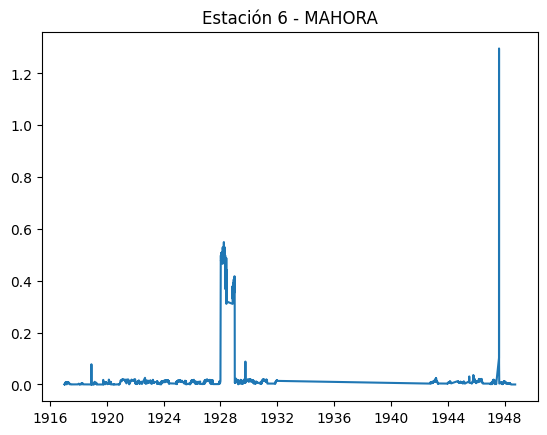

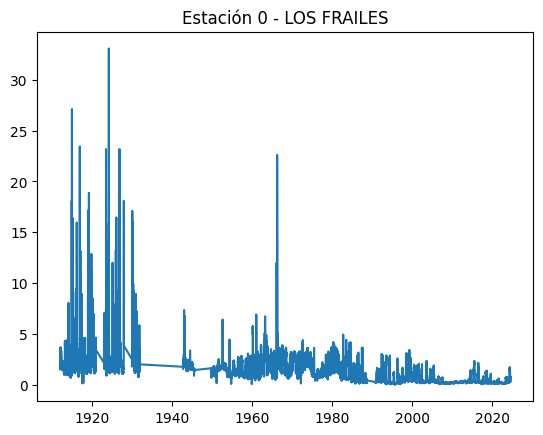

In [5]:
p_0 = df_rios[df_rios['location_id'] == 0].drop('location_id', axis = 1).groupby(['date']).mean()
p_6 = df_rios[df_rios['location_id'] == 6].drop('location_id', axis = 1).groupby(['date']).mean()
plt.plot(p_6)
plt.title('Estación 6 - MAHORA')
plt.show()
plt.plot(p_0)
plt.title('Estación 0 - LOS FRAILES')
plt.show()

In [6]:
df_rios = p_0.reset_index()

#### Aemet

In [7]:
df_aemet['location_id'].unique()

array([338, 340, 339], dtype=int64)

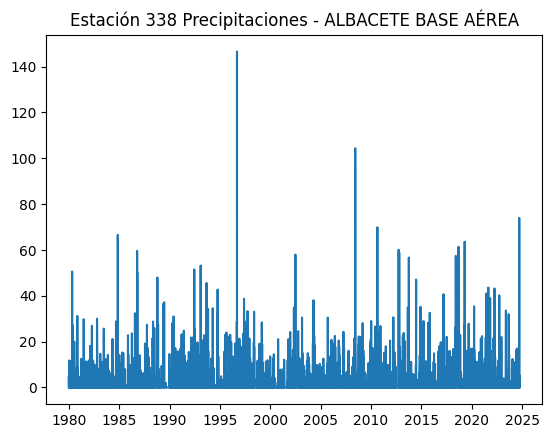

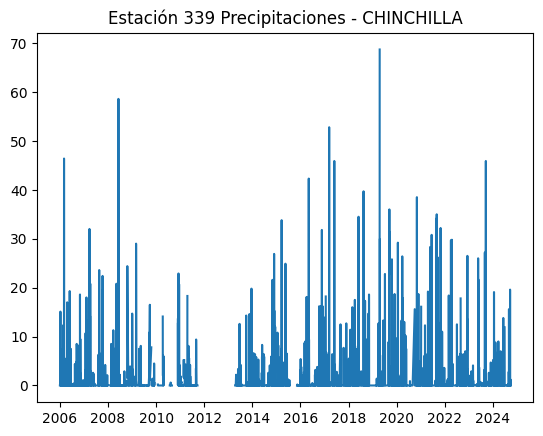

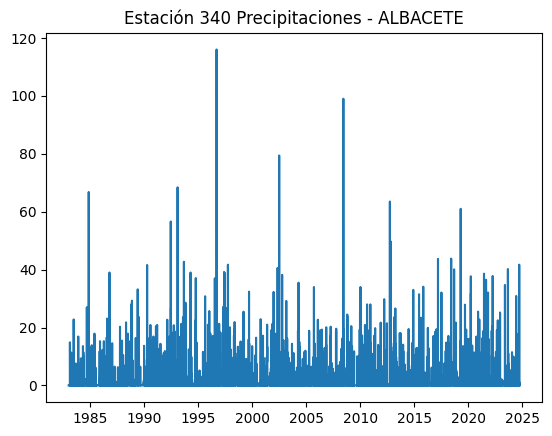

Correlación precipitaciones AEMET Base aerea y Chinchilla 0.7462543396854978
Correlación precipitaciones AEMET Base aerea y Albacete 0.9090030372895599
Correlación precipitaciones AEMET Albacete y Chinchilla 0.7873760843983788


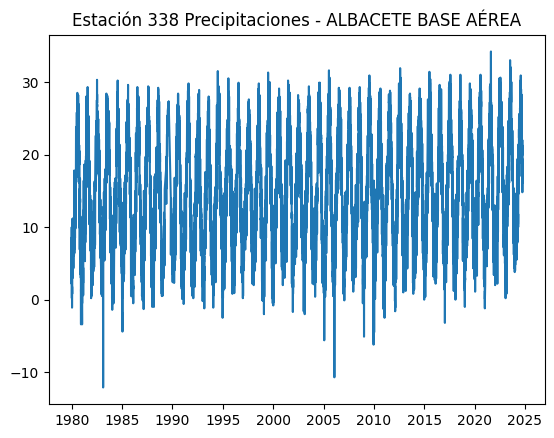

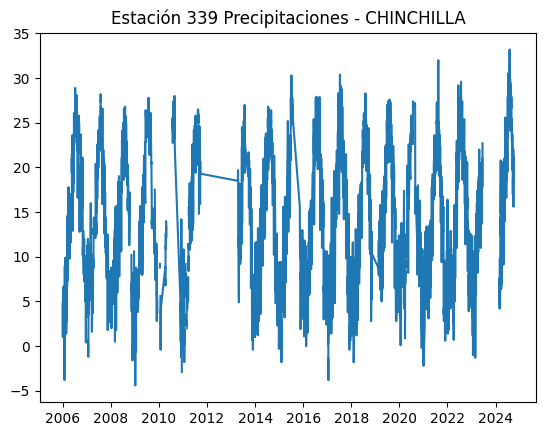

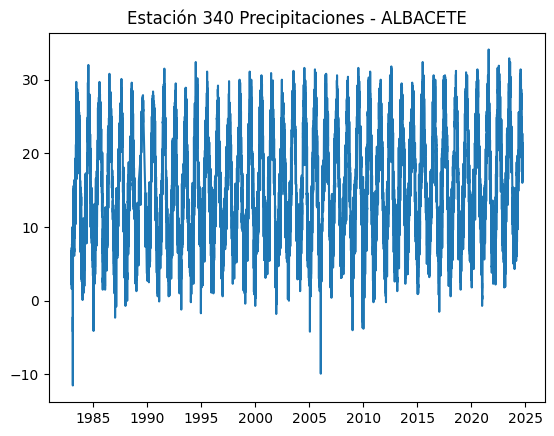

Correlación temperatura media AEMET Base aerea y Chinchilla 0.9852891361596875
Correlación temperatura media AEMET Base aerea y Albacete 0.9961737180904444
Correlación temperatura media AEMET Albacete y Chinchilla 0.9881351603742926


In [8]:
p_338 = df_aemet[df_aemet['location_id'] == 338].drop('location_id', axis = 1).groupby(['date']).mean()
p_339 = df_aemet[df_aemet['location_id'] == 339].drop('location_id', axis = 1).groupby(['date']).mean()
p_340 = df_aemet[df_aemet['location_id'] == 340].drop('location_id', axis = 1).groupby(['date']).mean()

plt.plot(p_338['prec'])
plt.title('Estación 338 Precipitaciones - ALBACETE BASE AÉREA')
plt.show()
plt.plot(p_339['prec'])
plt.title('Estación 339 Precipitaciones - CHINCHILLA')
plt.show()
plt.plot(p_340['prec'])
plt.title('Estación 340 Precipitaciones - ALBACETE')
plt.show()

print('Correlación precipitaciones AEMET Base aerea y Chinchilla',p_338['prec'].corr(p_339['prec']))
print('Correlación precipitaciones AEMET Base aerea y Albacete',p_338['prec'].corr(p_340['prec']))
print('Correlación precipitaciones AEMET Albacete y Chinchilla',p_339['prec'].corr(p_340['prec']))

plt.plot(p_338['tmed'])
plt.title('Estación 338 Precipitaciones - ALBACETE BASE AÉREA')
plt.show()
plt.plot(p_339['tmed'])
plt.title('Estación 339 Precipitaciones - CHINCHILLA')
plt.show()
plt.plot(p_340['tmed'])
plt.title('Estación 340 Precipitaciones - ALBACETE')
plt.show()

print('Correlación temperatura media AEMET Base aerea y Chinchilla',p_338['tmed'].corr(p_339['tmed']))
print('Correlación temperatura media AEMET Base aerea y Albacete',p_338['tmed'].corr(p_340['tmed']))
print('Correlación temperatura media AEMET Albacete y Chinchilla',p_339['tmed'].corr(p_340['tmed']))

Vemos que las precipitaciones y las temperaturas medias entre las tres estaciones son parecidas y que tienen una alta correlación entre ellas

In [9]:
df_aemet = df_aemet.drop('location_id',axis = 1).groupby('date').mean().reset_index()

#### Copernicus

In [10]:
#Enlazar soil water los 4 niveles en uno solo
df_c['soil_water'] = df_c['soil_water_l1'] + df_c['soil_water_l2'] + df_c['soil_water_l3'] + df_c['soil_water_l4']
df_c = df_c.drop(['soil_water_l1', 'soil_water_l2', 'soil_water_l3','soil_water_l4'], axis = 1)
df_c['soil_water'] = df_c['soil_water']/1e+6 #pasar a hectómetros cúbicos que es la unidad en la que está la cantidad de agua en ríos y embalses


In [11]:
df_x = pd.merge(df_c, df_aemet, on = 'date', how = 'inner')

In [12]:
df_x.set_index('date', inplace =True)

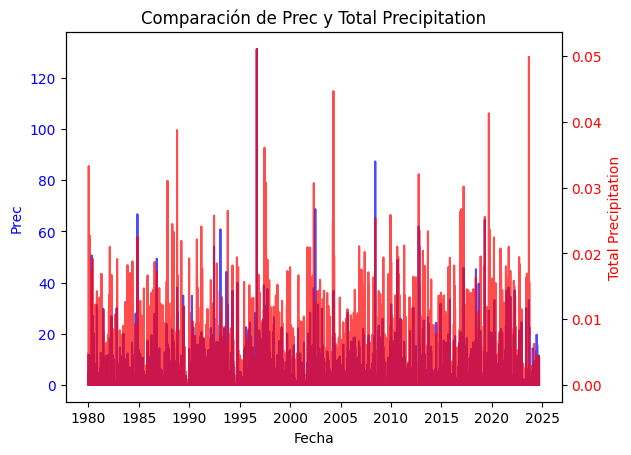

Correlacion entre datos de copernicus de lluvias y aemet de: 0.5995066587048061


In [13]:
# Crear la figura y el primer eje
fig, ax1 = plt.subplots()

# Graficar la primera serie (prec) en el primer eje y
ax1.plot(df_x['prec'], color='blue', label='Prec', alpha=0.7)
ax1.set_xlabel('Fecha')  # Etiqueta del eje x
ax1.set_ylabel('Prec', color='blue')  # Etiqueta del eje y para la primera serie
ax1.tick_params(axis='y', labelcolor='blue')  # Color de los ticks en el eje y para la primera serie

# Crear un segundo eje en el mismo gráfico para la segunda serie
ax2 = ax1.twinx()
ax2.plot(df_x['total_precipitation'], color='red', label='Total Precipitation', alpha=0.7)
ax2.set_ylabel('Total Precipitation', color='red')  # Etiqueta del eje y para la segunda serie
ax2.tick_params(axis='y', labelcolor='red')  # Color de los ticks en el eje y para la segunda serie

# Mostrar la gráfica
plt.title('Comparación de Prec y Total Precipitation')
plt.show()

print('Correlacion entre datos de copernicus de lluvias y aemet de:', df_x['prec'].corr(df_x['total_precipitation']))

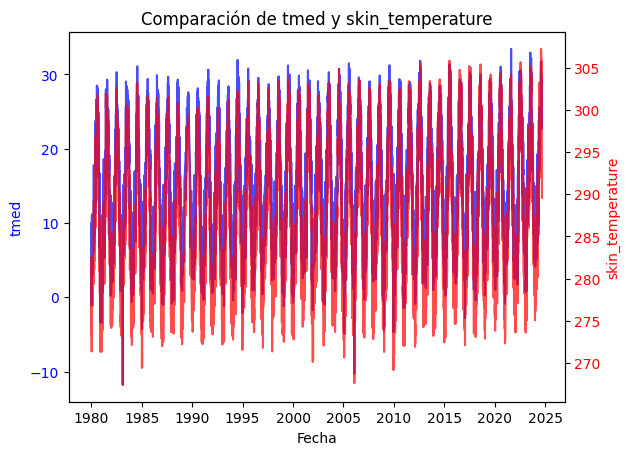

Correlacion entre datos de copernicus de temperaturas y aemet de: 0.9857287973009039


In [14]:
# Crear la figura y el primer eje
fig, ax1 = plt.subplots()

# Graficar la primera serie (prec) en el primer eje y
ax1.plot(df_x['tmed'], color='blue', label='Prec', alpha=0.7)
ax1.set_xlabel('Fecha')  # Etiqueta del eje x
ax1.set_ylabel('tmed', color='blue')  # Etiqueta del eje y para la primera serie
ax1.tick_params(axis='y', labelcolor='blue')  # Color de los ticks en el eje y para la primera serie

# Crear un segundo eje en el mismo gráfico para la segunda serie
ax2 = ax1.twinx()
ax2.plot(df_x['skin_temperature'], color='red', label='skin_temperature', alpha=0.7)
ax2.set_ylabel('skin_temperature', color='red')  # Etiqueta del eje y para la segunda serie
ax2.tick_params(axis='y', labelcolor='red')  # Color de los ticks en el eje y para la segunda serie

# Mostrar la gráfica
plt.title('Comparación de tmed y skin_temperature')
plt.show()
print('Correlacion entre datos de copernicus de temperaturas y aemet de:', df_x['tmed'].corr(df_x['skin_temperature']))

### Datos del río

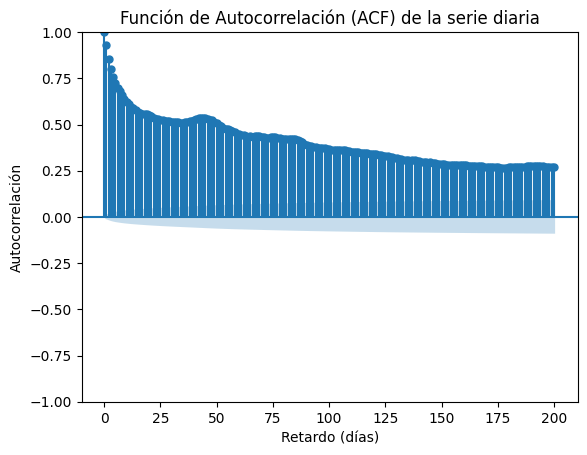

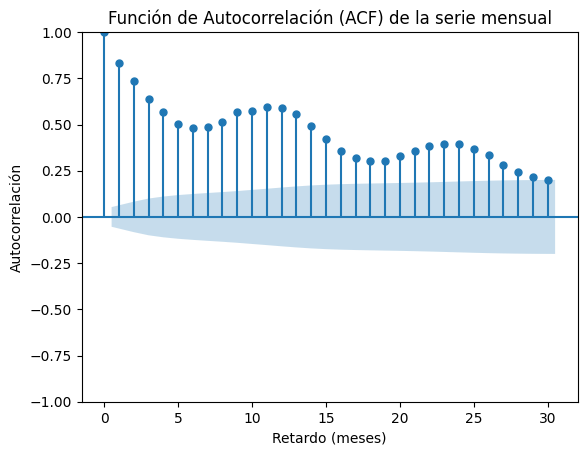

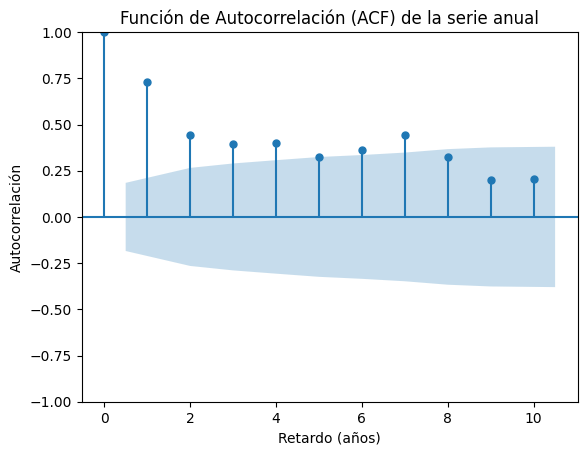

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

# Asegúrate de que la columna 'date' es un datetime y está como índice
df_rios['date'] = pd.to_datetime(df_rios['date'])
df_rios1 = df_rios.set_index('date')

# Autocorrelación diaria
plot_acf(df_rios1['quantity_hm3'], lags=200)
plt.title('Función de Autocorrelación (ACF) de la serie diaria')
plt.xlabel('Retardo (días)')
plt.ylabel('Autocorrelación')
plt.show()

# Autocorrelación mensual
monthly_series = df_rios1.resample('M').sum()  # Cambia a .sum() si quieres acumulados
plot_acf(monthly_series['quantity_hm3'], lags=30)
plt.title('Función de Autocorrelación (ACF) de la serie mensual')
plt.xlabel('Retardo (meses)')
plt.ylabel('Autocorrelación')
plt.show()

# Autocorrelación anual
annualy_series = df_rios1.resample('Y').sum()  # Cambia a .sum() si quieres acumulados
plot_acf(annualy_series['quantity_hm3'], lags=10)
plt.title('Función de Autocorrelación (ACF) de la serie anual')
plt.xlabel('Retardo (años)')
plt.ylabel('Autocorrelación')
plt.show()

#### Relación con las precipitaciones

##### Cantidad absoluta

###### Tiempo natural

In [32]:
#df = df.reset_index()
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')

# Agrupación mensual para calcular los valores agregados por mes
#monthly_agg = df.groupby('month_start')[variables].mean().reset_index() 
# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
#for var in variables:
    #for lag in lags_months:     
        # Crear promedios móviles de los últimos N meses
        #monthly_agg[f'{var}_mean_last{lag - 1} month'] = monthly_agg[var].rolling(window=lag).mean()

# Unir los resultados al DataFrame diario
#df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')
correlaciones = df.drop(['date','month_start'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)

total_precipitation_sum_last15 month    -0.243147
prec_sum_last15 month                   -0.239646
total_precipitation_sum_last100 month   -0.199033
prec_sum_last30 month                   -0.171211
prec_sum_last7 month                    -0.166799
total_precipitation_sum_last7 month     -0.165916
total_precipitation_sum_last1 month     -0.161565
prec_sum_last1 month                    -0.145695
total_precipitation_sum_last30 month    -0.131441
prec_sum_last60 month                   -0.093660
total_precipitation_sum_last60 month    -0.089818
total_precipitation                     -0.034399
prec                                    -0.024885
prec_sum_last100 month                   0.048443
quantity_hm3                             1.000000
Name: quantity_hm3, dtype: float64

###### Tiempo dinámico

In [33]:
#df = df.reset_index()
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']

# Lista de períodos para los cálculos
periods = [1, 7, 15, 30, 60,100]

for period in periods:
    for var in variables:
        # Promedios
        #df[f'{var}_mean_{period}d'] = df[var].rolling(window=period, min_periods=1).mean()
        # Sumas
        df[f'{var}_sum_{period}d'] = df[var].rolling(window=period, min_periods=1).sum()

correlaciones = df.drop(['date'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)

total_precipitation_sum_30d    -0.148453
total_precipitation_sum_60d    -0.138411
prec_sum_30d                   -0.137677
total_precipitation_sum_100d   -0.131218
total_precipitation_sum_15d    -0.125303
prec_sum_60d                   -0.118174
prec_sum_100d                  -0.112721
prec_sum_15d                   -0.110978
total_precipitation_sum_7d     -0.084307
prec_sum_7d                    -0.069073
total_precipitation            -0.034399
total_precipitation_sum_1d     -0.034399
prec                           -0.024885
prec_sum_1d                    -0.024885
quantity_hm3                    1.000000
Name: quantity_hm3, dtype: float64

##### Cantidad relativa

In [56]:
#df = df.reset_index()
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
        
# Calcular diferencias en quantity_hm3
df_quant = df[['month_start', 'quantity_hm3']].copy()
for lag in lags_months:
    df_quant[f'quantity_hm3_diff_{lag}'] = df_quant['quantity_hm3'].diff(lag)

# Unir los resultados al DataFrame diario
df = df.merge(
    monthly_agg.drop(columns=variables),
    on='month_start',
    how='left'
)
df = df.merge(
    df_quant.drop(columns=['quantity_hm3']),
    on='month_start',
    how='left'
)
# Inicializar un diccionario para almacenar las correlaciones
correlations_dict = {}

# Iterar sobre los lags de las variables y de quantity_hm3_diff_{lag}
for var in variables:
    for lag in lags_months:
        # Calcular la correlación entre el lag de la variable y el lag de quantity_hm3_diff
        lag_col = f'{var}_sum_last{lag} month'  # Nombre de la columna de la variable laggeada
        diff_col = f'quantity_hm3_diff_{lag}'  # Nombre de la columna de la diferencia de quantity_hm3
        
        correlation = df[lag_col].corr(df[diff_col])  # Correlación entre las dos columnas
            
            # Almacenar la correlación en el diccionario
        correlations_dict[f'{var}_lag{lag}_vs_quantity_hm3_diff_{lag}'] = correlation

# Convertir el diccionario de correlaciones a un DataFrame
correlations_df = pd.DataFrame.from_dict(correlations_dict, orient='index', columns=['Correlation'])
correlations_df = correlations_df.reset_index()
correlations_df.columns = ['Lag Combination', 'Correlation']
correlations_df

Lag Combination  Correlation
0     total_precipitation_lag1_vs_quantity_hm3_diff_1    -0.015039
1     total_precipitation_lag7_vs_quantity_hm3_diff_7     0.006077
2   total_precipitation_lag15_vs_quantity_hm3_diff_15     0.018825
3   total_precipitation_lag30_vs_quantity_hm3_diff_30     0.030800
4   total_precipitation_lag60_vs_quantity_hm3_diff_60     0.003678
5   total_precipitation_lag100_vs_quantity_hm3_dif...     0.056369
6                    prec_lag1_vs_quantity_hm3_diff_1    -0.013726
7                    prec_lag7_vs_quantity_hm3_diff_7     0.004438
8                  prec_lag15_vs_quantity_hm3_diff_15     0.024168
9                  prec_lag30_vs_quantity_hm3_diff_30     0.016597
10                 prec_lag60_vs_quantity_hm3_diff_60     0.016011
11               prec_lag100_vs_quantity_hm3_diff_100     0.045478

##### Lluvias en píxeles colindantes

In [134]:
query = f'''
    SELECT 
        p.location_id_copernicus, 
        l1.latitude AS latitude_copernicus, l1.longitude AS longitude_copernicus,
        l2.latitude AS latitude_embalses, l2.longitude AS longitude_embalses,
        l3.latitude AS latitude_aemet, l3.longitude AS longitude_aemet,
        l4.latitude AS latitude_rios, l4.longitude AS longitude_rios
    FROM df_pixeles_cercanos p
    -- Relacionar las localizaciones de la tabla df_pixeles_cercanos con las latitudes y longitudes
    LEFT JOIN locations_id l1 ON p.location_id_copernicus = l1.location_id 
    LEFT JOIN locations_id l2 ON p.location_id_embalses = l2.location_id
    LEFT JOIN locations_id l3 ON p.location_id_aemet = l3.location_id
    LEFT JOIN locations_id l4 ON p.location_id_rios_canales = l4.location_id
'''


# Ejecutar la consulta
cursor.execute(query)


# Función para calcular la distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    # Convertir de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Calcular la distancia
    distance = R * c
    return distance

# Obtener el DataFrame con las coordenadas
df_loc = pd.read_sql_query(query, conn)

# Eliminar filas duplicadas en las columnas relevantes (location_id_copernicus, latitude_copernicus, longitude_copernicus)
df_loc_unique = df_loc[['location_id_copernicus', 'latitude_copernicus', 'longitude_copernicus']].drop_duplicates()

# Obtener las coordenadas del location_id_copernicus == 189
target_location = df_loc_unique[df_loc_unique['location_id_copernicus'] == 189]
target_lat = target_location['latitude_copernicus'].values[0]
target_lon = target_location['longitude_copernicus'].values[0]

# Calcular la distancia a todos los demás location_id_copernicus
df_loc_unique['distance_to_189'] = df_loc_unique.apply(
    lambda row: haversine(target_lat, target_lon, row['latitude_copernicus'], row['longitude_copernicus']),
    axis=1
)

# Filtrar los location_id_copernicus colindantes (por ejemplo, aquellos con distancia menor a 1 km)
colindantes = df_loc_unique[df_loc_unique['distance_to_189'] < 80]


In [135]:
colindantes

location_id_copernicus  latitude_copernicus  longitude_copernicus  \
0                       189               39.174                -1.755   
6                       190               39.174                -1.255   
38                      182               38.674                -2.255   
42                      188               39.174                -2.255   
599                     194               39.674                -2.255   
622                     195               39.674                -1.755   
887                     196               39.674                -1.255   
903                     184               38.674                -1.255   
909                     183               38.674                -1.755   

     distance_to_189  
0           0.000000  
6          43.100834  
38         70.440912  
42         43.100834  
599        70.253137  
622        55.597463  
887        70.253137  
903        70.440912  
909        55.597463

In [136]:
m = folium.Map(location=[target_lat, target_lon], zoom_start=12)

# Añadir el marcador para el `location_id_copernicus == 189`
folium.Marker(
    location=[target_lat, target_lon],
    popup='location_id_copernicus == 189',
    icon=folium.Icon(color='red')
).add_to(m)

# Añadir marcadores para los puntos colindantes
for _, row in colindantes.iterrows():
    folium.Marker(
        location=[row['latitude_copernicus'], row['longitude_copernicus']],
        popup=f'location_id_copernicus == {row["location_id_copernicus"]}, Distancia: {row["distance_to_189"]:.2f} km',
        icon=folium.Icon(color='blue')
    ).add_to(m)
    
    # Añadir una línea entre `location_id_copernicus == 189` y el punto colindante
    folium.PolyLine(
        locations=[(target_lat, target_lon), (row['latitude_copernicus'], row['longitude_copernicus'])],
        color='green',
        weight=2.5,
        opacity=1
    ).add_to(m)
m

In [142]:
locations_colindantes  = colindantes['location_id_copernicus'].to_list()
locations_str = ', '.join(map(str, locations_colindantes))
query = f'''
        SELECT 
            d.date,
            c.location_id ,
            c.total_precipitation
            FROM df_copernicus c JOIN df_date d ON d.date_id = c.date_id  WHERE c.location_id IN ({locations_str});
        '''
# Ejecutar la consulta
cursor.execute(query)


df_colindantes_coper = pd.read_sql_query(query, conn)

In [144]:
df_colindantes_coper_pivot = df_colindantes_coper.pivot(index='date', columns='location_id', values='total_precipitation')

In [146]:
df_colindantes_coper_pivot.corr()

location_id       182       183       184       188       189       190  \
location_id                                                               
182          1.000000  0.964215  0.877986  0.943395  0.933687  0.867554   
183          0.964215  1.000000  0.954683  0.884224  0.947602  0.936570   
184          0.877986  0.954683  1.000000  0.800107  0.899927  0.948564   
188          0.943395  0.884224  0.800107  1.000000  0.960587  0.855361   
189          0.933687  0.947602  0.899927  0.960587  1.000000  0.952246   
190          0.867554  0.936570  0.948564  0.855361  0.952246  1.000000   
194          0.825397  0.752514  0.671026  0.946064  0.888078  0.762615   
195          0.841232  0.813857  0.746164  0.942079  0.935235  0.854574   
196          0.806195  0.837966  0.825577  0.862620  0.918764  0.938757   

location_id       194       195       196  
location_id                                
182          0.825397  0.841232  0.806195  
183          0.752514  0.813857  0.837966  
184          0.671026  0.746164  0.825577  
188          0.946064  0.942079  0.862620  
189          0.888078  0.935235  0.918764  
190          0.762615  0.854574  0.938757  
194          1.000000  0.959437  0.847469  
195          0.959437  1.000000  0.944282  
196          0.847469  0.944282  1.000000

In [149]:
df_colindantes_coper_pivot = df_colindantes_coper_pivot.reset_index()

In [154]:
df_colindantes_coper_pivot['date'] = pd.to_datetime(df_colindantes_coper_pivot['date'])

In [165]:
df_merge = pd.merge(df,df_colindantes_coper_pivot, on ='date')[['date','quantity_hm3', 182, 183, 184, 188, 189, 190, 194, 195, 196]]

# Variables para calcular retardos, acumulados y promedios móviles
variables = [182, 183, 184, 188, 189, 190, 194, 195, 196]
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df_merge['month_start'] = df_merge['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df_merge.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df_merge = df_merge.merge(monthly_agg.drop( [182, 183, 184, 188, 189, 190, 194, 195, 196], axis = 1), left_on='month_start', right_on='month_start', how='left')

# Agrupación mensual para calcular los valores agregados por mes
#monthly_agg = df.groupby('month_start')[variables].mean().reset_index() 
# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
#for var in variables:
    #for lag in lags_months:     
        # Crear promedios móviles de los últimos N meses
        #monthly_agg[f'{var}_mean_last{lag - 1} month'] = monthly_agg[var].rolling(window=lag).mean()

# Unir los resultados al DataFrame diario
#df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')
correlaciones = df_merge.drop(['date','month_start'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)[1:50]

190_sum_last15 month    -0.297239
183_sum_last15 month    -0.268868
196_sum_last15 month    -0.259134
184_sum_last30 month    -0.256449
184_sum_last100 month   -0.246550
189_sum_last15 month    -0.243147
182_sum_last15 month    -0.240574
190_sum_last100 month   -0.237086
184_sum_last60 month    -0.234455
183_sum_last100 month   -0.229461
190_sum_last30 month    -0.228190
184_sum_last7 month     -0.223098
190_sum_last7 month     -0.218931
188_sum_last15 month    -0.211021
194_sum_last15 month    -0.206619
196_sum_last100 month   -0.204971
195_sum_last15 month    -0.201661
189_sum_last100 month   -0.199033
194_sum_last1 month     -0.198827
183_sum_last60 month    -0.192177
190_sum_last60 month    -0.191476
196_sum_last7 month     -0.188614
188_sum_last1 month     -0.188061
183_sum_last30 month    -0.184381
182_sum_last1 month     -0.181436
196_sum_last30 month    -0.180963
182_sum_last100 month   -0.179036
183_sum_last7 month     -0.178079
184_sum_last1 month     -0.167011
189_sum_last7 

##### Lluvias con frecuencia baja

In [166]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')

C:\Users\idelatorre\AppData\Local\Temp\ipykernel_22072\4035553041.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['prec'], shade=True, color="blue")


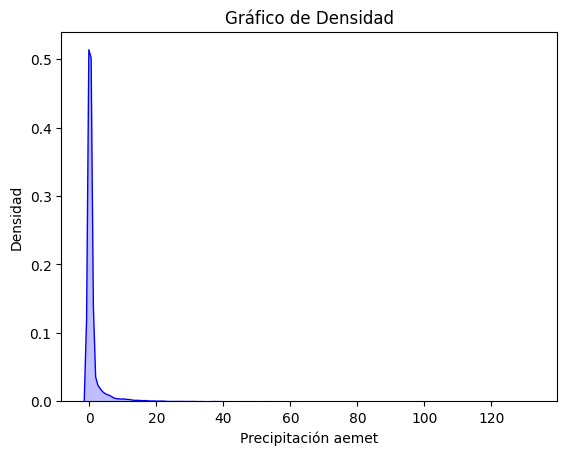

In [187]:
import seaborn as sns

sns.kdeplot(df['prec'], shade=True, color="blue")

plt.title('Gráfico de Densidad')
plt.xlabel('Precipitación aemet')
plt.ylabel('Densidad')

plt.show()


In [180]:
df_precBaja = df[df['prec']<df['prec'].mean()]
df_tpBaja = df[df['total_precipitation']<df['total_precipitation'].mean()]

In [184]:
# Variables para calcular retardos, acumulados y promedios móviles
variables = ['prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df_precBaja['month_start'] = df_precBaja['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df_precBaja.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df_precBaja = df_precBaja.merge(monthly_agg.drop( ['prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')


C:\Users\idelatorre\AppData\Local\Temp\ipykernel_22072\338456587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precBaja['month_start'] = df_precBaja['date'].dt.to_period('M').dt.start_time


In [186]:
df_precBaja.corr()['quantity_hm3']

date                     -0.457983
total_precipitation      -0.008790
skin_temperature          0.281741
evaporation              -0.225397
runoff                   -0.009046
snowfall                 -0.021748
high_vegetation_cover    -0.025630
low_vegetation_cover      0.025630
soil_water               -0.123034
tmed                      0.273247
prec                     -0.043069
quantity_hm3              1.000000
month_start              -0.457995
prec_sum_last1 month     -0.181411
prec_sum_last7 month     -0.081163
prec_sum_last15 month    -0.176996
prec_sum_last30 month    -0.081423
prec_sum_last60 month    -0.076841
prec_sum_last100 month   -0.127092
Name: quantity_hm3, dtype: float64

##### Filtrando tiempo

In [35]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[df['date'].dt.year < 1990]
# Variables para calcular retardos, acumulados y promedios móviles
variables = ['prec','total_precipitation']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop( ['prec','total_precipitation'], axis = 1), left_on='month_start', right_on='month_start', how='left')


In [195]:
df.corr()['quantity_hm3']

date                                    -0.594677
total_precipitation                     -0.038100
skin_temperature                         0.306806
evaporation                             -0.207965
runoff                                  -0.078871
snowfall                                 0.009152
high_vegetation_cover                         NaN
low_vegetation_cover                          NaN
soil_water                              -0.484056
tmed                                     0.274442
prec                                    -0.008887
quantity_hm3                             1.000000
month_start                             -0.594854
prec_sum_last1 month                    -0.103076
prec_sum_last7 month                     0.008829
prec_sum_last15 month                   -0.099537
prec_sum_last30 month                   -0.221175
prec_sum_last60 month                   -0.410191
prec_sum_last100 month                   0.253057
total_precipitation_sum_last1 month     -0.141757


##### Estacionalidades

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')

vars = ['quantity_hm3','total_precipitation_sum_last1 month',
       'total_precipitation_sum_last7 month',
       'total_precipitation_sum_last15 month',
       'total_precipitation_sum_last30 month',
       'total_precipitation_sum_last60 month',
       'total_precipitation_sum_last100 month', 'prec_sum_last1 month',
       'prec_sum_last7 month', 'prec_sum_last15 month',
       'prec_sum_last30 month', 'prec_sum_last60 month',
       'prec_sum_last100 month']
for i in vars:
    estacionalidad = seasonal_decompose(df[i].dropna(), model='additive', period=50).seasonal
    df[f'season_{i}'] = estacionalidad

df_estacionalidades = df[[i for i in df.columns if i[0:6] == 'season']]

df_estacionalidades.corr()['season_quantity_hm3'].sort_values(ascending = False)

#df['Estacionalidad_precipitacion_15_dias_copenicus'] = prec_cop.seasonal
#df['Estacionalidad_precipitacion_15_dias_aemet'] = prec_aemet.seasonal
#df['Estacionalidad_cantidad_agua'] = prec_agua.seasonal

season_quantity_hm3                             1.000000
season_prec_sum_last1 month                     0.454127
season_total_precipitation_sum_last1 month      0.417748
season_prec_sum_last15 month                    0.358477
season_total_precipitation_sum_last15 month     0.277769
season_prec_sum_last100 month                   0.009866
season_prec_sum_last30 month                   -0.070854
season_total_precipitation_sum_last30 month    -0.087439
season_total_precipitation_sum_last60 month    -0.151051
season_prec_sum_last60 month                   -0.231874
season_total_precipitation_sum_last7 month     -0.273640
season_prec_sum_last7 month                    -0.292837
season_total_precipitation_sum_last100 month   -0.326816
Name: season_quantity_hm3, dtype: float64

##### Estacionalidades generalizando

Todo lo que hemos hecho lo encapsulamos en funciones, functions.py y buscamos mejores correlaciones de lluvias con cantidad de agua

In [16]:
from Functions import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')

In [18]:
df = df[['date','total_precipitation','quantity_hm3']]

In [19]:
df_dia, df_mes, df_año = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}

for frecuent, lags in lags_dict.items():
    # Calcular retardos acumulados
    df_aggNat = retardAgg_tNat(df=df.copy(), vars=['total_precipitation'], lags=lags, frec=frecuent)
    df_avgNat = retardAvg_tNat(df=df.copy(), vars=['total_precipitation'], lags=lags, frec=frecuent)

    # Variables a procesar (excluyendo fecha)
    variables_agg = df_aggNat.drop(columns=['date']).columns
    variables_avg = df_avgNat.drop(columns=['date']).columns

    # Crear las estacionalidades
    for var in variables_agg:
        for est in range(10, 210, 10):
            if len(df_aggNat[var].dropna()) >= est:  # Verificar longitud suficiente
                estacionalidad = seasonal_decompose(df_aggNat[var].dropna(), model='additive', period=est).seasonal
                df_aggNat[f'season_{var}_{est}'] = estacionalidad
            else:
                df_aggNat[f'season_{var}_{est}'] = np.nan

    for var in variables_avg:
        for est in range(10, 210, 10):
            if len(df_avgNat[var].dropna()) >= est:  # Verificar longitud suficiente
                estacionalidad = seasonal_decompose(df_avgNat[var].dropna(), model='additive', period=est).seasonal
                df_avgNat[f'season_{var}_{est}'] = estacionalidad
            else:
                df_avgNat[f'season_{var}_{est}'] = np.nan

    # Filtrar columnas que contienen estacionalidades
    estacionalidades_aggNat = [col for col in df_aggNat.columns if col.startswith('season_')]
    estacionalidades_avgNat = [col for col in df_avgNat.columns if col.startswith('season_')]

    df_estacionalidades_aggNat = df_aggNat[estacionalidades_aggNat]
    df_estacionalidades_avgNat = df_avgNat[estacionalidades_avgNat]

    # Calcular correlaciones si las columnas están presentes
    corr_aggNat = (
        df_estacionalidades_aggNat.corr()['season_quantity_hm3']
        if 'season_quantity_hm3' in df_estacionalidades_aggNat.columns
        else pd.Series(dtype=float)
    )

    corr_avgNat = (
        df_estacionalidades_avgNat.corr()['season_quantity_hm3']
        if 'season_quantity_hm3' in df_estacionalidades_avgNat.columns
        else pd.Series(dtype=float)
    )

    # Concatenar resultados
    df_corr = pd.concat([corr_aggNat, corr_avgNat])
    if frecuent == 'D':
        df_dia = pd.concat([df_dia, df_corr], ignore_index=True)
    elif frecuent == 'M':
        df_mes = pd.concat([df_mes, df_corr], ignore_index=True)
    elif frecuent == 'Y':
        df_año = pd.concat([df_año, df_corr], ignore_index=True)


C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragme

In [77]:
lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
df_est_aggNat_corr = {}
for frecuent, lags in lags_dict.items():
    df_est_aggNat_corr[frecuent] = {}
    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    df_aggNat = df_aggNat.drop(f'{frecuent}_start', axis = 1)
    vars = df_aggNat.drop(['date', 'quantity_hm3'], axis = 1).columns
    for est in range(10,210,10):
        df_est_aggNat_corr[frecuent][est] = {}
        estacionalidad_quantity = seasonal_decompose(df_aggNat['quantity_hm3'].dropna(), model='additive', period=est).trend
        for var in vars:
            estacionalidad_var = seasonal_decompose(df_aggNat[var].dropna(), model='additive', period=est).trend
            corr_aggNat = estacionalidad_var.corr(estacionalidad_quantity)
            df_est_aggNat_corr[frecuent][est][var] = corr_aggNat

C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragme

In [80]:
pd.DataFrame(df_est_aggNat_corr['M']).T

total_precipitation  total_precipitation_sum_last1M  \
10             -0.093000                       -0.170777   
20             -0.128477                       -0.178164   
30             -0.151318                       -0.184346   
40             -0.165684                       -0.191322   
50             -0.175304                       -0.198509   
60             -0.182569                       -0.205458   
70             -0.189954                       -0.212231   
80             -0.196889                       -0.218295   
90             -0.202842                       -0.223256   
100            -0.206918                       -0.227662   
110            -0.209925                       -0.231664   
120            -0.213025                       -0.235513   
130            -0.217927                       -0.239637   
140            -0.222753                       -0.243928   
150            -0.227690                       -0.248175   
160            -0.232310                       -0.252019   
170            -0.237197                       -0.255430   
180            -0.241091                       -0.258651   
190            -0.244345                       -0.261359   
200            -0.246845                       -0.263498   

     total_precipitation_sum_last2M  total_precipitation_sum_last3M  \
10                        -0.189955                       -0.190979   
20                        -0.196287                       -0.196805   
30                        -0.201060                       -0.201498   
40                        -0.205191                       -0.205838   
50                        -0.209285                       -0.210041   
60                        -0.213484                       -0.214313   
70                        -0.217921                       -0.218786   
80                        -0.222381                       -0.223410   
90                        -0.226772                       -0.228316   
100                       -0.231062                       -0.233449   
110                       -0.235085                       -0.238667   
120                       -0.239119                       -0.244099   
130                       -0.243283                       -0.249765   
140                       -0.247397                       -0.255572   
150                       -0.251309                       -0.261184   
160                       -0.254875                       -0.266307   
170                       -0.258233                       -0.271009   
180                       -0.261288                       -0.275001   
190                       -0.263829                       -0.278041   
200                       -0.266084                       -0.280486   

     total_precipitation_sum_last4M  total_precipitation_sum_last5M  \
10                        -0.178545                       -0.171571   
20                        -0.184109                       -0.177523   
30                        -0.189165                       -0.182380   
40                        -0.194303                       -0.187288   
50                        -0.199472                       -0.192456   
60                        -0.204895                       -0.197895   
70                        -0.210593                       -0.203712   
80                        -0.216499                       -0.209839   
90                        -0.222586                       -0.216318   
100                       -0.228731                       -0.222872   
110                       -0.234926                       -0.229284   
120                       -0.241276                       -0.235812   
130                       -0.247789                       -0.242280   
140                       -0.254466                       -0.248505   
150                       -0.260897                       -0.254685   
160                       -0.266581                       -0.260765   
170                       -0.271722          

In [ ]:
# lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
df_est_aggNat_corr = {}

for frecuent, lags in lags_dict.items():
    # Inicializar clave de frecuencia si no existe
    if frecuent not in df_est_aggNat_corr:
        df_est_aggNat_corr[frecuent] = {}

    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_aggNat.drop(['date', 'quantity_hm3'], axis=1).columns
    df_aggNat = df_aggNat.drop('D_start', axis=1, errors='ignore')  # Ignorar errores si no existe

    for est in range(10, 210, 10):
        # Inicializar clave de estacionalidad si no existe
        if est not in df_est_aggNat_corr[frecuent]:
            df_est_aggNat_corr[frecuent][est] = {}

        # Calcular estacionalidades
        estacionalidad_quantity = seasonal_decompose(df_aggNat['quantity_hm3'].dropna(), model='additive', period=est).seasonal

        for var in vars:
            # Calcular estacionalidad de la variable
            estacionalidad_var = seasonal_decompose(df_aggNat[var].dropna(), model='additive', period=est).seasonal
            
            # Calcular correlación
            corr_aggNat = estacionalidad_var.corr(estacionalidad_quantity)
            
            # Asignar el resultado al diccionario
            df_est_aggNat_corr[frecuent][est][var] = corr_aggNat


In [42]:
df_dia = pd.DataFrame()
df_mes = pd.DataFrame()
df_año = pd.DataFrame()
lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
for frecuent, lags in lags_dict.items():
    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_aggNat.drop('date', axis = 1).columns
    for i in vars:
            estacionalidad = seasonal_decompose(df_aggNat[i].dropna(), model='additive', period=50).seasonal
            df_aggNat[f'season_{i}_{est}'] = estacionalidad
            
    df_estacionalidades_aggNat = df_aggNat[[i for i in df_aggNat.columns if i[0:6] == 'season']]
    corr_aggNat = df_estacionalidades_aggNat.corr()['season_quantity_hm3']

    ####################################
    df_avgNat = retardAvg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_avgNat.drop('date', axis = 1).columns
    for i in vars:
            estacionalidad = seasonal_decompose(df_avgNat[i].dropna(), model='additive', period=50).seasonal
            df_avgNat[f'season_{i}{est}'] = estacionalidad
        
    df_estacionalidades_avgNat = df_avgNat[[i for i in df_avgNat.columns if i[0:6] == 'season']]
    corr_avgNat = df_estacionalidades_avgNat.corr()['season_quantity_hm3']

    #####################################
    df_corr = pd.concat([corr_aggNat, corr_avgNat])
    if frecuent == 'D':
        df_dia = pd.concat([df_corr, df_dia])
    elif frecuent == 'M':
        df_mes = pd.concat([df_corr, df_mes])
    elif frecuent == 'Y':
        df_año = pd.concat([df_corr, df_año])

C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragme

KeyError: 'season_quantity_hm3'

In [46]:
df_estacionalidades_aggNat.columns

Index(['season_total_precipitation_90', 'season_quantity_hm3_90',
       'season_D_start_90', 'season_total_precipitation_sum_last1D_90',
       'season_total_precipitation_sum_last2D_90',
       'season_total_precipitation_sum_last3D_90',
       'season_total_precipitation_sum_last4D_90',
       'season_total_precipitation_sum_last5D_90',
       'season_total_precipitation_sum_last6D_90',
       'season_total_precipitation_sum_last7D_90',
       ...
       'season_total_precipitation_sum_last291D_90',
       'season_total_precipitation_sum_last292D_90',
       'season_total_precipitation_sum_last293D_90',
       'season_total_precipitation_sum_last294D_90',
       'season_total_precipitation_sum_last295D_90',
       'season_total_precipitation_sum_last296D_90',
       'season_total_precipitation_sum_last297D_90',
       'season_total_precipitation_sum_last298D_90',
       'season_total_precipitation_sum_last299D_90',
       'season_total_precipitation_sum_last300D_90'],
      dtype='o

In [ ]:
df_estacionalidades_aggNat.corr()['season_quantity_hm3']

In [63]:
df_dia[df_dia['quantity_hm3']>0]

index  quantity_hm3
1  quantity_hm3           1.0
1  quantity_hm3           1.0

In [64]:
df_mes[df_mes['quantity_hm3']>0]

index  quantity_hm3
1  quantity_hm3           1.0
1  quantity_hm3           1.0

In [65]:
df_año[df_año['quantity_hm3']>0]

index  quantity_hm3
1  quantity_hm3           1.0
1  quantity_hm3           1.0

In [246]:
retardAgg_tDin(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)

ValueError: invalid on specified as date, must be a column (of DataFrame), an Index or None

In [249]:
df

date  total_precipitation  skin_temperature  evaporation  \
0     1979-12-25             0.004725         279.58880    -0.000654   
1     1979-12-26             0.000028         276.78476    -0.000585   
2     1979-12-27             0.000000         274.31525    -0.000369   
3     1979-12-28             0.000168         277.16278    -0.000210   
4     1979-12-29             0.000055         278.06170    -0.000474   
...          ...                  ...               ...          ...   
14997 2024-09-01             0.000019         300.68950    -0.000106   
14998 2024-09-02             0.004281         300.15360    -0.000280   
14999 2024-09-03             0.001827         298.29828    -0.000694   
15000 2024-09-04             0.000541         296.73508    -0.000653   
15001 2024-09-05             0.000148         289.58585    -0.000036   

             runoff      snowfall  high_vegetation_cover  \
0      7.036887e-05  0.000000e+00               0.532379   
1      1.243316e-07  0.000000e+00               0.532379   
2      0.000000e+00  2.384186e-07               0.532379   
3      1.043314e-06  0.000000e+00               0.532379   
4      1.556473e-07  0.000000e+00               0.532379   
...             ...           ...                    ...   
14997  0.000000e+00  0.000000e+00               0.293182   
14998  1.683459e-05  0.000000e+00               0.293182   
14999  6.807037e-06  0.000000e+00               0.293182   
15000  1.996756e-06  0.000000e+00               0.293182   
15001  4.354806e-07  0.000000e+00               0.293182   

       low_vegetation_cover  soil_water       tmed       prec  quantity_hm3  \
0                  0.466477    0.000008   8.500000   4.500000      2.611872   
1                  0.466477    0.000008   3.600000   0.000000      2.664576   
2                  0.466477    0.000008   2.200000   0.000000      2.664576   
3                  0.466477    0.000008   5.800000   0.000000      2.664576   
4                  0.466477    0.000008   6.300000   0.000000      2.717280   
...                     ...         ...        ...        ...           ...   
14997              0.686639    0.000003  25.966667   0.066667      0.760147   
14998              0.686639    0.000003  24.700000  11.500000      0.759370   
14999              0.686639    0.000003  25.066667   0.133333      0.793757   
15000              0.686639    0.000003  23.800000   0.000000      0.785549   
15001              0.686639    0.000001  22.733333   0.000000      0.770688   

         D_start  
0     1979-12-25  
1     1979-12-26  
2     1979-12-27  
3     1979-12-28  
4     1979-12-29  
...          ...  
14997 2024-09-01  
14998 2024-09-02  
14999 2024-09-03  
15000 2024-09-04  
15001 2024-09-05  

[15002 rows x 13 columns]

#### Regresión

In [207]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
# Variables para calcular retardos, acumulados y promedios móviles
variables = ['prec','total_precipitation']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop( ['prec','total_precipitation'], axis = 1), left_on='month_start', right_on='month_start', how='left').dropna()


In [208]:
import statsmodels.api as sm
predictors = ['prec_sum_last1 month', 'prec_sum_last7 month', 'prec_sum_last15 month',
       'prec_sum_last30 month', 'prec_sum_last60 month',
       'prec_sum_last100 month', 'total_precipitation_sum_last1 month',
       'total_precipitation_sum_last7 month',
       'total_precipitation_sum_last15 month',
       'total_precipitation_sum_last30 month',
       'total_precipitation_sum_last60 month',
       'total_precipitation_sum_last100 month']

X = df[predictors]
y = df['quantity_hm3']

# Agregar una constante para el intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           quantity_hm3   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     300.9
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:17:45   Log-Likelihood:                -8459.1
No. Observations:               12133   AIC:                         1.694e+04
Df Residuals:                   12120   BIC:                         1.704e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     3.1025      0.102     30.513      0.000       2.903       3.302
prec_sum_last1 month                  -3.417e-05      0.000     -0.110      0.912      -0.001       0.001
prec_sum_last7 month                      0.0009      0.000      5.163      0.000       0.001       0.001
prec_sum_last15 month                     0.0013      0.000      9.664      0.000       0.001       0.002
prec_sum_last30 month                    -0.0005   9.25e-05     -5.375      0.000      -0.001      -0.000
prec_sum_last60 month                    -0.0011    6.5e-05    -17.227      0.000      -0.001      -0.001
prec_sum_last100 month                    0.0013   3.87e-05     34.630      0.000       0.001       0.001
total_precipitation_sum_last1 month      -2.1753      0.344     -6.332      0.000      -2.849      -1.502
total_precipitation_sum_last7 month      -1.2599      0.175     -7.194      0.000      -1.603      -0.917
total_precipitation_sum_last15 month     -2.7106      0.150    -18.059      0.000      -3.005      -2.416
total_precipitation_sum_last30 month      1.4575      0.101     14.433      0.000       1.260       1.655
total_precipitation_sum_last60 month      0.9415      0.064     14.764      0.000       0.817       1.067
total_precipitation_sum_last100 month    -1.9617      0.052    -37.604      0.000      -2.064      -1.859
==============================================================================
Omnibus:                     4270.204   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14606.997
Skew:                           1.794   Prob(JB):                         0.00
Kurtosis:                       7.003   Cond. No.                     2.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Arbol de regresión

In [108]:
df = df.drop(['trend_prec_cop',
'trend_prec_aemet',
'trend_prec_agua',
'seas_prec_cop',
'seas_prec_aemet',
'seas_prec_agua'], axis = 1)

In [112]:
df = df.set_index('date')

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=['quantity_hm3'])
y = df['quantity_hm3']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el árbol de regresión
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

importancias = tree.feature_importances_

# Crear un DataFrame para visualización
importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Predicciones
y_pred = tree.predict(X_test)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"R² (coeficiente de determinación): {r2}")

Error cuadrático medio (MSE): 0.4783994591918622
R² (coeficiente de determinación): 0.09053639881517317


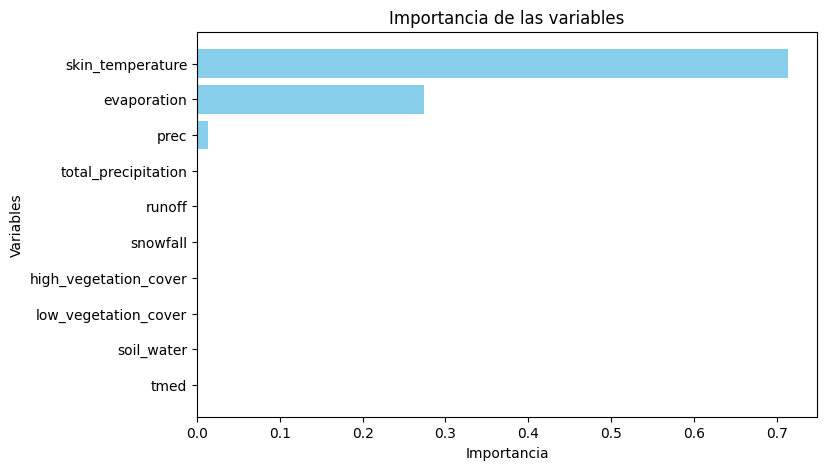

In [115]:
plt.figure(figsize=(8, 5))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables')
plt.gca().invert_yaxis()
plt.show()

#### Regresión lineal

In [116]:
import statsmodels.api as sm

X = df[['skin_temperature', 'evaporation', 'prec']]

# Añadir una constante para el intercepto
X = sm.add_constant(X)

y = df['quantity_hm3']
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           quantity_hm3   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     571.4
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:21:34   Log-Likelihood:                -15539.
No. Observations:               15002   AIC:                         3.109e+04
Df Residuals:                   14998   BIC:                         3.112e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3518      0.199    -26.854      0.000      -5.742      -4.961
skin_temperature     0.0202      0.001     28.821      0.000       0.019       0.022
evaporation       -158.9714      7.905    -20.110      0.000    -174.467    -143.476
prec                -0.0027      0.001     -1.827      0.068      -0.006       0.000
==============================================================================
Omnibus:                     5197.640   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16522.763
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                       6.667   Cond. No.                     4.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
correlaciones = df.corr()

correlaciones_quantity_hm3 = correlaciones['quantity_hm3']
correlaciones_filtradas = correlaciones_quantity_hm3[abs(correlaciones_quantity_hm3) > 0.2]

# Ordenar las correlaciones en orden descendente
correlaciones_filtradas = correlaciones_filtradas.sort_values(ascending=False)
correlaciones_filtradas